**Proyecto- Segmentación en grupos de acuerdo a características de pacientes**

Integrantes: Maria Fernanda De La Hoz, Silvana Sandoval y Gabriela Soler 


Este proyecto tiene el objetivo de incorporar herramientas de Inteligencia Artificial para incrementar la eficiencia de la prestación de servicios a los usuarios en las diferentes IPS asociadas, teniendo en cuenta que en el contexto del triage, la agrupación puede ser útil para la toma de decisiones.

**Entendimiento de los datos**

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("202420_Laboratorio 2 - Agrupación_202420_Laboratorio_2_-_Agrupación_data.csv", encoding="latin1", sep=",")
print(data.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...    BT  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...  36.2        98.0               2   
1      1         4  140.0  ...  36.3        99.0               3   
2      1         3  100.0  ...  36.4        98.0               4   
3      1         4  120.0  ...  36.5        99.0               4   
4      0    #BOÃ!  143.0  ...  38.1         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain           

Vamos a ver el número de registros y de columnas con el que contamos

In [126]:
data.shape

(1000, 23)

In [127]:
print(data.describe())

             Grupo         Sexo         Edad  Modo_Llegada     Lesion  \
count  1000.000000  1000.000000  1000.000000   1000.000000  1000.0000   
mean      1.450000     1.514000    53.892000      2.811000     1.2000   
std       0.497743     0.500054    19.826483      0.796186     0.4002   
min       1.000000     1.000000    16.000000      1.000000     1.0000   
25%       1.000000     1.000000    36.000000      2.000000     1.0000   
50%       1.000000     2.000000    56.000000      3.000000     1.0000   
75%       2.000000     2.000000    70.250000      3.000000     1.0000   
max       2.000000     2.000000    94.000000      7.000000     2.0000   

       Estado_Mental        Dolor         SBP         DBP          HR  \
count    1000.000000  1000.000000  983.000000  979.000000  988.000000   
mean        1.103000     0.562000  133.485249   79.566905   84.400810   
std         0.431946     0.496389   27.156136   15.174593   16.297428   
min         1.000000     0.000000   50.000000   31

**Análisis de las variables para la implementación del proyecto**

*Variables Categóricas:*

Grupo: Es una variable importante porque parece clasificar a los pacientes en grupos que queremos optimizar.

Sexo, Modo_Llegada, Lesión, Estado_Mental, Dolor: Estas variables categorizadas probablemente influyan en la clasificación y deberían codificarse adecuadamente.

*Variables de Severidad:*
KTAS_Enfermera y KTAS_Experto: Estas escalas son importantes para evaluar la urgencia de los pacientes. Es clave tenerlas en cuenta en el modelo de agrupamiento.

Disposición: Esta variable refleja qué pasó con el paciente después de la evaluación, lo que podría ser útil para encontrar patrones en los resultados del tratamiento.

*Variables Numéricas:*

Las variables fisiológicas como SBP (Presión Arterial Sistólica), DBP (Presión Diastólica), HR (Frecuencia Cardíaca), RR (Frecuencia Respiratoria), BT (Temperatura Corporal), y Saturación (Oxígeno) son críticas para describir el estado físico del paciente.

Variables de tiempo como Duración_Estancia_Min y Duración_KTAS_Min también son importantes porque podrían ayudar a analizar la eficiencia de la atención.

*Variables que podrían tener ruido:*

Grupo_Error, Error_Triaje: Si estamos trabajando para hacer agrupamientos basados en la condición de los pacientes, estas columnas relacionadas con errores podrían introducir ruido o ser útiles para analizar el rendimiento de los grupos predichos.

**Manejo de variables faltantes**

Para las variables críticas (por ejemplo, las fisiológicas y de severidad), podemos usar imputación. Es por esto que identificaremos cuáles columnas tienen valores faltantes y cuántos faltan:

In [128]:
data.isnull().sum()

Grupo                         0
Sexo                          0
Edad                          0
Modo_Llegada                  0
Lesion                        0
Queja_Principal               0
Estado_Mental                 0
Dolor                         0
dolor_NRS                     0
SBP                          17
DBP                          21
HR                           12
RR                           15
BT                           11
Saturacion                  556
KTAS_enfermera                0
Diagnostico_En_Urgencias      1
Disposicion                   0
KTAS_experto                  0
Grupo_De_Error                0
Duracion_Estancia_Min         0
Duracion_KTAS_Min             0
Error_Triaje                  0
dtype: int64

Para las variables fisiológicas con pocos valores faltantes (SBP, DBP, HR, RR, BT):
Podemos usar imputación con la mediana. La mediana es robusta a valores atípicos y adecuada para variables fisiológicas.

Para la variable Saturacion, que tiene más del 50% de los datos faltantes:
Podríamos considerar imputar con la mediana también, pero como tiene demasiados valores faltantes, otra opción sería eliminar esta columna si no es esencial para el análisis.

Para Diagnostico_En_Urgencias, que tiene solo un valor faltante:
Imputar con el valor más frecuente será una estrategia razonable.

In [129]:
#Iniciaremos creando una copia de los datos para realizar un preprocesamiento
data_copy = data.copy()

In [130]:
# Imputar las variables fisiológicas con la mediana
data_copy['SBP'].fillna(data_copy['SBP'].median(), inplace=True)
data_copy['DBP'].fillna(data_copy['DBP'].median(), inplace=True)
data_copy['HR'].fillna(data_copy['HR'].median(), inplace=True)
data_copy['RR'].fillna(data_copy['RR'].median(), inplace=True)
data_copy['BT'].fillna(data_copy['BT'].median(), inplace=True)

# Para la saturación, decidimos imputar con la mediana
data_copy['Saturacion'].fillna(data_copy['Saturacion'].median(), inplace=True)

# Imputar el Diagnóstico en Urgencias con el valor más frecuente
data_copy['Diagnostico_En_Urgencias'].fillna(data_copy['Diagnostico_En_Urgencias'].mode()[0], inplace=True)


C:\Users\silva\AppData\Local\Temp\ipykernel_10140\3558805917.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy['SBP'].fillna(data_copy['SBP'].median(), inplace=True)
C:\Users\silva\AppData\Local\Temp\ipykernel_10140\3558805917.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [131]:
print(data_copy.isnull().sum())

Grupo                       0
Sexo                        0
Edad                        0
Modo_Llegada                0
Lesion                      0
Queja_Principal             0
Estado_Mental               0
Dolor                       0
dolor_NRS                   0
SBP                         0
DBP                         0
HR                          0
RR                          0
BT                          0
Saturacion                  0
KTAS_enfermera              0
Diagnostico_En_Urgencias    0
Disposicion                 0
KTAS_experto                0
Grupo_De_Error              0
Duracion_Estancia_Min       0
Duracion_KTAS_Min           0
Error_Triaje                0
dtype: int64


Ya que solucionamos el problema de las variables faltantes, procederemos al tratamiento de las variables categóricas. Como los algoritmos de agrupamiento requieren variables numéricas, vamos a convertir las variables categóricas a un formato numérico.

Utilizaremos Label Encoding para variables ordinales como KTAS_Enfermera, Estado_Mental, y Disposición, donde los valores tienen un orden implícito, y One-Hot Encoding para variables nominales como Modo_Llegada y Lesion.

In [132]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data_copy['KTAS_Enfermera'] = le.fit_transform(data_copy['KTAS_enfermera'])
data_copy['Estado_Mental'] = le.fit_transform(data_copy['Estado_Mental'])
data_copy['Disposición'] = le.fit_transform(data_copy['Disposicion'])

data_copy = pd.get_dummies(data, columns=['Modo_Llegada', 'Lesion', 'Sexo'], drop_first=True)

In [133]:
print(data_copy.head())

   Grupo  Edad  Queja_Principal  Estado_Mental  Dolor dolor_NRS    SBP   DBP  \
0      2    49  ant. chest pain              1      1         2  150.0  90.0   
1      2    30         headache              1      1         4  140.0  80.0   
2      2    61  ant. chest pain              1      1         3  100.0  60.0   
3      2    61         headache              1      1         4  120.0  70.0   
4      1    67    fever & chill              1      0    #BOÃ!  143.0  70.0   

      HR    RR  ...  Duracion_KTAS_Min  Error_Triaje  Modo_Llegada_2  \
0   92.0  20.0  ...               2,00             0            True   
1   76.0  20.0  ...               3,00             0           False   
2   84.0  20.0  ...               2,00             0           False   
3   76.0  20.0  ...               2,00             2           False   
4  130.0  20.0  ...               3,60             2           False   

  Modo_Llegada_3  Modo_Llegada_4  Modo_Llegada_5  Modo_Llegada_6  \
0          False  

Al revisar los datos podemos ver que hay algunas entradas que tienen "," en lugar de ".", los que generará un problema en la normalización de los datos. Por lo que es necesario remplazar este carácter y convertir el formato del dato a float.

In [134]:
# Reemplazar comas por puntos en las columnas que contienen números decimales almacenados como texto
data_copy['Duracion_KTAS_Min'] = data_copy['Duracion_KTAS_Min'].str.replace(',', '.').astype(float)
data_copy['dolor_NRS'] = data_copy['dolor_NRS'].replace(',', '.', regex=True)

Ahora procederemos a realizar una normalización de los datos, puesto que las variables numéricas deben estar en una escala común, especialmente si estamos implementando un algoritmo basado en distancias, como K-means. Es por esto, que normalizaremos las variables fisiológicas, de tiempo, y de edad.

In [135]:
from sklearn.preprocessing import MinMaxScaler

# Seleccionar las columnas numéricas que queremos normalizar
numerical_cols = ['Edad', 'SBP', 'DBP', 'HR', 'RR', 'BT', 'Saturacion', 'Duracion_Estancia_Min', 'Duracion_KTAS_Min']

# Inicializar el escalador Min-Max y aplicar
scaler = MinMaxScaler()
data_copy[numerical_cols] = scaler.fit_transform(data_copy[numerical_cols])

# Revisar los datos normalizados
print(data_copy.head())

   Grupo      Edad  Queja_Principal  Estado_Mental  Dolor dolor_NRS       SBP  \
0      2  0.423077  ant. chest pain              1      1         2  0.444444   
1      2  0.179487         headache              1      1         4  0.400000   
2      2  0.576923  ant. chest pain              1      1         3  0.222222   
3      2  0.576923         headache              1      1         4  0.311111   
4      1  0.653846    fever & chill              1      0    #BOÃ!  0.413333   

        DBP        HR     RR  ...  Duracion_KTAS_Min  Error_Triaje  \
0  0.457364  0.517241  0.375  ...           0.061087             0   
1  0.379845  0.379310  0.375  ...           0.122175             0   
2  0.224806  0.448276  0.375  ...           0.061087             0   
3  0.302326  0.379310  0.375  ...           0.061087             2   
4  0.302326  0.844828  0.375  ...           0.158827             2   

   Modo_Llegada_2 Modo_Llegada_3  Modo_Llegada_4  Modo_Llegada_5  \
0            True       

Ahora, debido a que vamos a comprabar el número de categorias que hay en las variables categóricas.

In [136]:
data["Queja_Principal"].value_counts()

Queja_Principal
abd pain                               62
dizziness                              53
dyspnea                                45
ant. chest pain                        37
fever                                  29
                                       ..
hand laceration                         1
Sexual Abuse of Adult                   1
laceration, scalp                       1
right lower quadrant abdominal pain     1
otalgia, Rt.                            1
Name: count, Length: 347, dtype: int64

In [137]:
data["dolor_NRS"].value_counts()

dolor_NRS
#BOÃ!    440
3         209
4         111
5         109
6          59
2          31
7          27
8           8
10          3
1           2
9           1
Name: count, dtype: int64

In [138]:
data["Diagnostico_En_Urgencias"].value_counts()

Diagnostico_En_Urgencias
Acute gastroenteritis                                   39
Headache                                                23
Dizziness                                               20
Unspecified abdominal pain                              19
Ischaemic chest pain                                    17
                                                        ..
Colon cancer, sigmoid                                    1
Postnasal drip syndrome                                  1
Other specified diabetes mellitus, with hypoglycemia     1
Open wound of finger(s) without damage to nail           1
Traumatic secondary and recurrent haemorrhage            1
Name: count, Length: 489, dtype: int64

Ahora, procedemos a contar el número de datos nulos por columna para tener una idea clara de si estos se pueden reemplazar o si,por le contrario, seben ser eliminados.

In [139]:
print("Valores nulos por columna: ")
print(data.isnull().sum())

Valores nulos por columna: 
Grupo                         0
Sexo                          0
Edad                          0
Modo_Llegada                  0
Lesion                        0
Queja_Principal               0
Estado_Mental                 0
Dolor                         0
dolor_NRS                     0
SBP                          17
DBP                          21
HR                           12
RR                           15
BT                           11
Saturacion                  556
KTAS_enfermera                0
Diagnostico_En_Urgencias      1
Disposicion                   0
KTAS_experto                  0
Grupo_De_Error                0
Duracion_Estancia_Min         0
Duracion_KTAS_Min             0
Error_Triaje                  0
dtype: int64


Por último, vamos a ver el porcentaje de datos faltantes para decidir si borrar columnas o reemplazar por medias.

In [140]:
features = ["Sexo", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "SBP", "DBP", "HR", "RR", "Saturacion", "Disposicion"]

data[["Duracion_Estancia_Min"] + features].isnull().sum() / data.shape[0] * 100

Duracion_Estancia_Min     0.0
Sexo                      0.0
Modo_Llegada              0.0
Lesion                    0.0
Estado_Mental             0.0
Dolor                     0.0
SBP                       1.7
DBP                       2.1
HR                        1.2
RR                        1.5
Saturacion               55.6
Disposicion               0.0
dtype: float64

Ahora, revisaremos los duplicados para tener una idea de cuantos registros serán borrados para evitar sesgos

In [141]:
duplicate_rows = data.duplicated().sum()
print(f"Número de filas duplicadas: {duplicate_rows}")

Número de filas duplicadas: 33


Ahora vamos a revisar los outliers, esto con el propósito de saber qué tan extremos son ya que si son demasiado diferentes al resto de los datos, esto puede ocasionar problemas en algortimos como K-Means ya que es sensible a los datos extremos

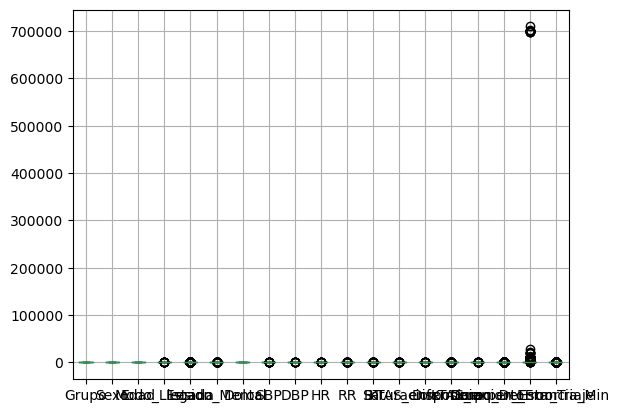

In [142]:
data.boxplot()

# Show the plot
plt.show()

## Limpieza de los datos

Para empezar la limpieza de los datos, vamos a hacer una copia de los datos para evitar dañar el conjunto original.

In [143]:
dataCopy = data.copy()

Luego, vamos a eliminar los datos duplicados. Esto se hace con el objetivo de evitar sesgos en el modelo.

In [144]:
dataCopy = dataCopy.drop_duplicates()

Después de borrar los duplicados, procederemos a borrar la columna de Saturacion ya que sus registros faltantes son más el 50%, por lo cual se puede inferir que no aporta mucha información relevante para el modelo.

In [145]:
dataCopy = dataCopy.drop(columns=['Diagnostico_En_Urgencias'])
dataCopy = dataCopy.drop(columns=['Queja_Principal'])
dataCopy = dataCopy.drop(columns=['dolor_NRS'])

Ahora procedermos a eliminar las columnas categóricas ya que estas tienen muchas clases, lo cual podría causar problemas al momento de transformarlas en númericas.

In [146]:
dataCopy = dataCopy.drop(columns=['Saturacion'])

Después, vamos a eliminar los registros que tienen datos faltantes ya que, al no ser muchos después de borrar la columna saturación, no se pierde información valiosa para el modelo.

In [147]:
dataCopy=dataCopy.dropna()

Por último, borraremos los outliers muy extremos de la variable Duración_Estancia_Min. Esto lo vamos a hacer a partir de del valor de 50.000 ya que hay valores muy extremos sobre este valore que pueden alterar la forma en la que K-Means genera los grupos.

In [148]:
dataCopy = dataCopy[dataCopy["Duracion_Estancia_Min"]<=50000]

Ahora vamos a ver el número de datos y columnas que quedan.

In [149]:
dataCopy.shape

(928, 19)

## Ajuste de los datos para que esten en una misma escala

Una vez que hemos limpiado y preparado los datos, podemos proceder a implementar un modelo de agrupamiento. Para empezar, vamos a usar K-means para ver si podemos identificar grupos de pacientes con características similares. 

In [150]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# kmeans = KMeans(n_clusters=3, random_state=42)

# kmeans.fit(data_copy)
# data_copy['Cluster'] = kmeans.labels_

# print(data_copy['Cluster'].value_counts())